In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

import logging

from ihrem import timeslice
from ihrem.timeslice import Win, ms
from ihrem import paths

from ihrem.analysis import video as vid
from ihrem.analysis import stim
from ihrem.analysis import entrainment as ent

from ihrem import traces as tr

import warnings

warnings.simplefilter(action='error', category=FutureWarning)
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.WARNING)

In [3]:
from ihrem.figs_cpg import fig4

reg_full = paths.Registry.read_excel()

In [4]:

reg_sel = reg_full.sel_mask(
    reg_full['cap'].isna() &
    (reg_full['lesion'] != 'BST') &
    reg_full['lights'].notna() &
    reg_full['stim'].isin(['dark pulses']) &
    reg_full['state'].isin(['awake']) &
    reg_full.is_bilat('CLA')
)

print(f'{len(reg_sel)}/{len(reg_full)}')

reg_sel.reg.fillna('none').value_counts(['lesion',  'cap', 'stim', 'state', 'probe']).rename('counts').unstack(['stim', 'lesion', 'cap'], fill_value=0).sort_index(axis=1).T

38/204


state                          awake                      
probe                   CamNeurotech neuronexus neuropixel
stim        lesion cap                                    
dark pulses amyg   none            0          2          0
            ctx    none            0         10          0
            none   none            5         16          5

In [5]:
exp_light_wins = stim.load_light_wins_multi(reg_sel)

ent.group_pulses_multi(exp_light_wins)

# manually patch this one experiment, where one of the 90s pulses is actually 83s
# which makes the automated protocol detection "fail"
exp_light_wins['GL903_20200717_awake']['train'] = exp_light_wins['GL903_20200717_awake']['train'].map({
    1: 1,
    2: 2,
    3: 2,
    4: 2,
    5: 3,
    6: 4.    
})


all_light_wins = timeslice.Windows.concat(exp_light_wins, cycle_name='exp_name')

all_trains = ent.extract_train_protocol_multi(exp_light_wins)

all_trains = all_trains.sort_values(['pulse_len', 'interval', 'pulse_count']).reset_index().rename_index('train_id')

display(all_trains.value_counts(['interval', 'pulse_len', 'pulse_count']).unstack('interval', fill_value=0).sort_index().T)


exp_lum = stim.load_all_lum_traces(reg_sel)
exp_lum = tr.Traces.from_dict_resampled(exp_lum, ['exp_name'])

exp_beta_detailed = reg_sel.load_all_beta_traces_multi(area='CLA').normalize_by_quantiles()
exp_beta_comb = exp_beta_detailed.groupby_max('exp_name')

  0%|          | 0/38 [00:00<?, ?it/s]

pulse_len   30000.0        45000.0        60000.0            ...        \
pulse_count       11 12 16       11 16 18       3  9  10 11  ... 13 16   
interval                                                     ...         
30000.0            1  1  1        0  0  0        0  0  0  0  ...  0  0   
45000.0            0  0  0        0  2  1        0  0  0  0  ...  0  1   
60000.0            0  0  0        1  0  0        1  1  3  5  ...  3  0   
70000.0            0  0  0        0  0  0        0  0  0  0  ...  0  0   
80000.0            0  0  0        0  0  0        0  0  0  0  ...  0  0   
90000.0            0  0  0        0  0  0        0  0  0  0  ...  0  0   
180000.0           0  0  0        0  0  0        0  0  0  0  ...  0  0   

pulse_len   70000.0  80000.0  90000.0           120000.0 180000.0  
pulse_count       10       9        3  7  10 12       11       6   
interval                                                           
30000.0            0        0        0  0  0  0        0        0  
45000.0            0        0        0  0  1  0        0        0  
60000.0            0        0        0  0  0  0        1        0  
70000.0            1        0        0  0  0  0        0        0  
80000.0            0        1        0  0  0  0        0        0  
90000.0            0        0        1  1  2  2        0        0  
180000.0           0        0        0  0  0  0        0        1  

[7 rows x 21 columns]

  0%|          | 0/38 [00:00<?, ?it/s]

load beta:   0%|          | 0/38 [00:00<?, ?it/s]

In [6]:
fig4.detect_protocol_end(exp_light_wins, all_trains)

protocol_colors = fig4.get_protocol_colors(all_trains)


In [7]:
%%time

exp_dlc = vid.load_deeplabcut_multi(
    reg_sel.collect_paths_deeplabcut()
)

exp_dlc = vid.adjust_deeplabcut_time_multi(reg_sel.sel(probe='neuropixel', but=True), exp_dlc)


find:   0%|          | 0/38 [00:00<?, ?it/s]

/gpfs/laur/data/fenkl/claustrum/Claustrum II/2021-05-03_11-41-25/DeepLabCut/cam0_2021-05-03-11-45-35DLC_resnet_50_EyeTrackingNoseMay6shuffle1_200000_filtered.csv
/gpfs/laur/data/fenkl/claustrum/Claustrum II/2021-05-03_11-41-25/DeepLabCut/cam0_2021-05-03-11-45-35DLC_resnet_50_EyeTrackingNoseMay6shuffle1_200000.csv
Taking:
/gpfs/laur/data/fenkl/claustrum/Claustrum II/2021-05-03_11-41-25/DeepLabCut/cam0_2021-05-03-11-45-35DLC_resnet_50_EyeTrackingNoseMay6shuffle1_200000.csv
/gpfs/laur/data/fenkl/GL1071_20210711_awake4_g0/DeepLabCut/cam0_2021-07-11-13-10-26DLC_resnet_50_EyeTracking2021Jul26shuffle1_200000.csv
/gpfs/laur/data/fenkl/GL1071_20210711_awake4_g0/DeepLabCut/cam0_2021-07-11-13-10-26DLC_resnet_50_EyeTracking2021Jul26shuffle1_200000_filtered.csv
Taking:
/gpfs/laur/data/fenkl/GL1071_20210711_awake4_g0/DeepLabCut/cam0_2021-07-11-13-10-26DLC_resnet_50_EyeTracking2021Jul26shuffle1_200000.csv
/gpfs/laur/data/fenkl/GL1071_20210715_awake6_g0/DeepLabCut/cam0_2021-07-15-10-15-24DLC_resnet_50

load:   0%|          | 0/12 [00:00<?, ?it/s]

adjust:   0%|          | 0/12 [00:00<?, ?it/s]

GL1078_20201024_awake time adjusted by 699.30 ms
GL1078_20201026_awake_10 time adjusted by 226.08 ms
GL1003_20201103_awake time adjusted by 122.33 ms
GL1003_20201104_awake_11 time adjusted by 112.33 ms
GL1062_20210129_awake_11 time adjusted by 124.45 ms
GL1062_20210130_awake_1401 time adjusted by 76.02 ms
GL1062_20210219_awake_1140 time adjusted by 91.33 ms


GL1076_20210503_awake_11 time adjusted by 45.36 ms
CPU times: user 11.7 s, sys: 1.02 s, total: 12.7 s
Wall time: 18.2 s


In [8]:
%%time

exp_eyes = vid.extract_eye_open_multi(exp_dlc)

exp_eyes

interp:   0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 1.46 s, sys: 299 ms, total: 1.75 s
Wall time: 1.78 s


# Fig 4a: keep lights off

Saving: /gpfs/laur/data/fenkl/from_luis/fig3/lights_off_single_beta.pdf


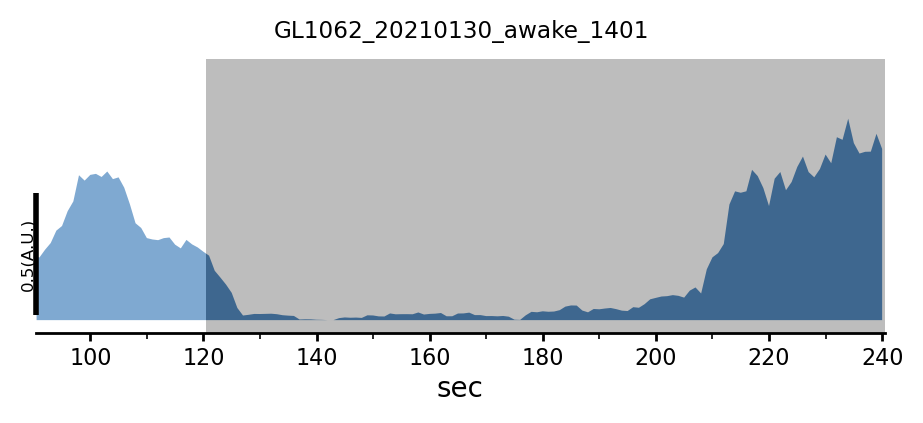

In [9]:
f = fig4.plot_single_example(exp_beta_detailed, exp_light_wins, exp_name='GL1062_20210130_awake_1401', ch=0)
fig4.savefig(f, 'lights_off_single_beta')

# Fig 4ce: multiple experiments

In [10]:
align_wins = all_trains.around((ms(hours=-2), ms(hours=+2)), q='last_on')

lum_aligned = exp_lum.cut_merge(align_wins, left_on=['exp_name'], right_on=['exp_name'])
beta_aligned = exp_beta_comb.cut_merge(align_wins, left_on=['exp_name'], right_on=['exp_name'])
light_wins_aligned = fig4.align_windows_dict(exp_light_wins, align_wins)

In [11]:
eyes_aligned = exp_eyes.cut_merge(align_wins, left_on=['exp_name'], right_on=['exp_name'])
eyes_aligned

Saving: /gpfs/laur/data/fenkl/from_luis/fig3/awake_beta_aligned_last_off_medians.pdf


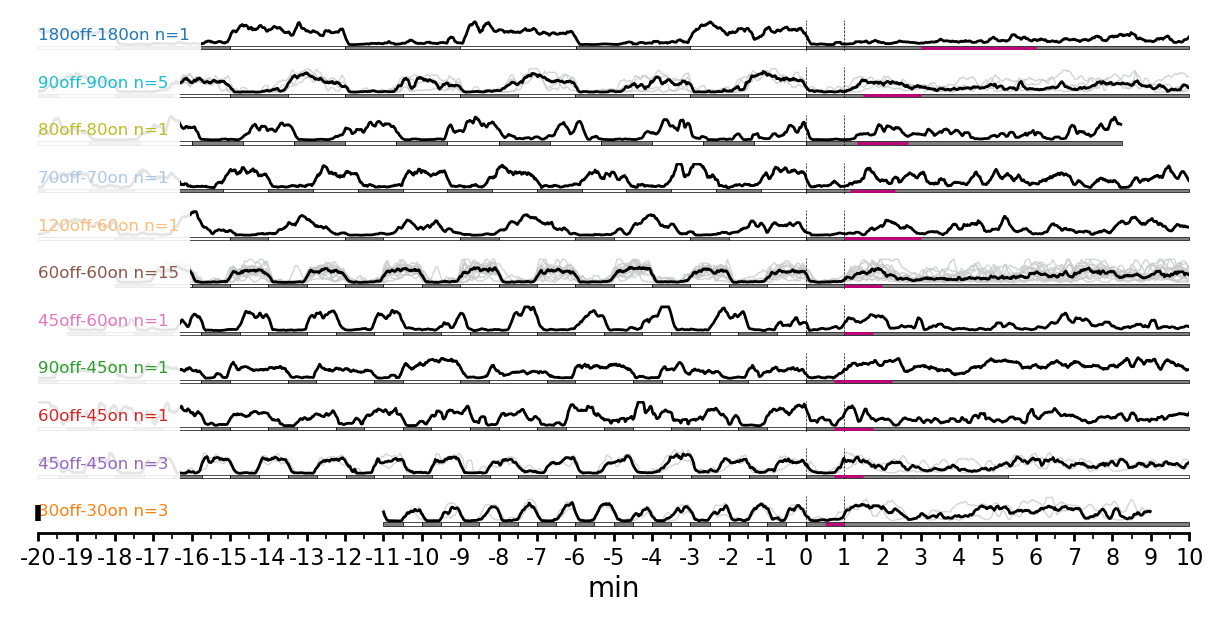

In [12]:
f = fig4.plot_summary_overlaid_by_protocol(
    beta_aligned.sel(dark_after=True).sel_between(pulse_count=(4, np.inf)).sort_values(['interval', 'pulse_len', 'pulse_count'], ascending=False),
    light_wins_aligned,
    protocol_colors,
)

fig4.savefig(f, 'awake_beta_aligned_last_off_medians')

  0%|          | 0/36 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig3/awake_beta_aligned_last_off.pdf


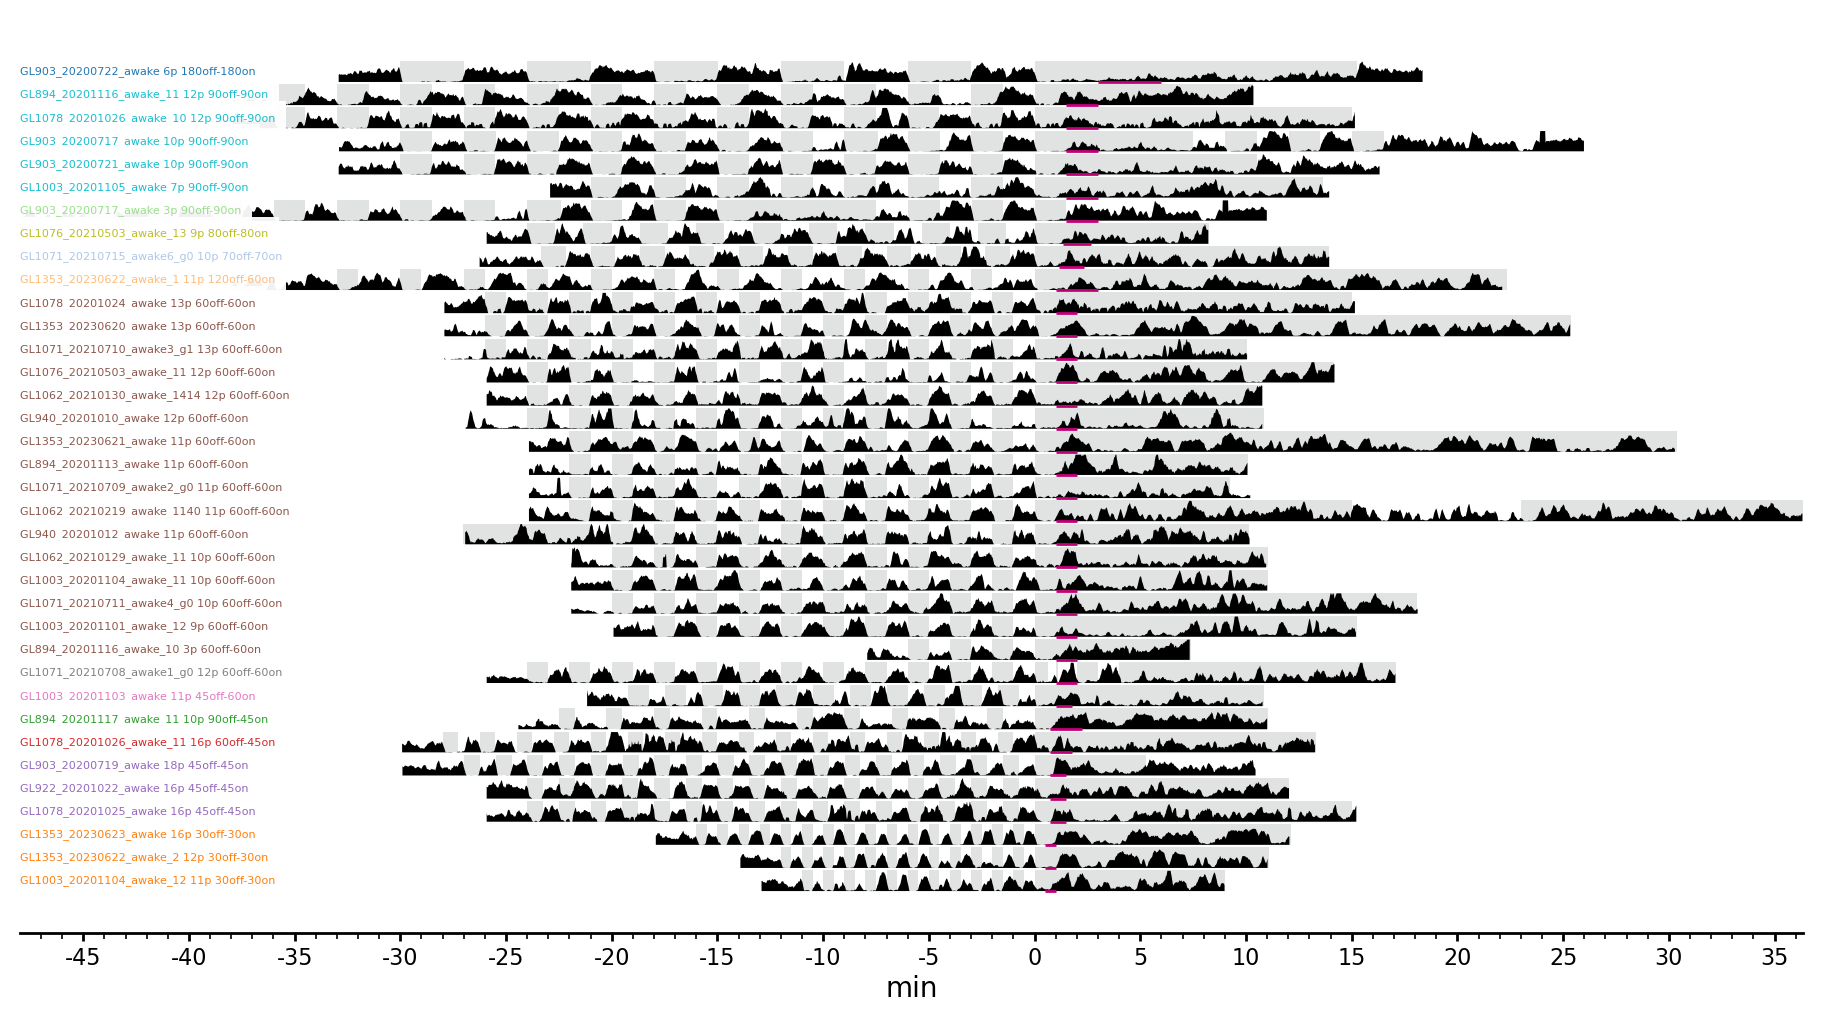

In [13]:
f = fig4.plot_summary_spread(beta_aligned.downsample(1000).clip(0, 1.5) * .65, light_wins_aligned, protocol_colors)
fig4.savefig(f, 'awake_beta_aligned_last_off')

In [14]:

fig4.report_reset_times(
    beta_aligned,
    [
        (60_000, 0.2),
        (90_000, 0.4),
    ]
)

for 60s, median: 61.5; IQR: [59.7, 68.9]; n=15
for 90s, median: 82.0; IQR: [80.3, 95.5]; n=5


In [15]:
beta_sel = beta_aligned.sel_mask(beta_aligned['interval'] == beta_aligned['pulse_len']).sel(dark_after=True).sel_between(pulse_count=(4, np.inf))
fig4.print_animal_counts(
    beta_sel
)

30s: 2, 3
45s: 3, 3
60s: 8, 15
70s: 1, 1
80s: 1, 1
90s: 4, 5
180s: 1, 1
Total: 29 (10)


# Fig 4d: 2 rebounds with spikes

In [16]:
exp_spiking = fig4.load_spiking_multi(
    reg_sel.collect_paths_jrclust(),
    reg_sel,
)

for exp_name, spikes in exp_spiking.items():
    print(f'{exp_name}: {spikes.describe_str()}')

find:   0%|          | 0/38 [00:00<?, ?it/s]

load:   0%|          | 0/9 [00:00<?, ?it/s]

GL903_20200717_awake: 16,267 spikes from 7 cells, between (+00:00, +00:59:04.419)
GL903_20200719_awake: 3,430 spikes from 2 cells, between (+00:00, +00:40:32.664)
GL940_20201010_awake: 83,268 spikes from 30 cells, between (+00:00, +00:37:52.020)
GL1078_20201024_awake: 4,365 spikes from 2 cells, between (+00:00, +00:43:15.473)
GL1003_20201101_awake_12: 18,573 spikes from 5 cells, between (+00:00, +00:35:18.200)
GL1003_20201103_awake: 47,107 spikes from 9 cells, between (+00:00, +00:32:08.565)
GL1003_20201104_awake_11: 28,782 spikes from 10 cells, between (+00:00, +00:33:06.661)
GL1003_20201104_awake_12: 23,208 spikes from 13 cells, between (+00:00, +00:22:05.554)
GL1003_20201105_awake: 9,569 spikes from 8 cells, between (+00:00, +00:37:02.121)


In [17]:
exp_name = 'GL903_20200717_awake'
spikes = exp_spiking[exp_name]

beta = exp_beta_detailed.sel(exp_name=exp_name)

lfp = fig4.load_lfp(reg_sel, exp_name, load_hz=1_000)

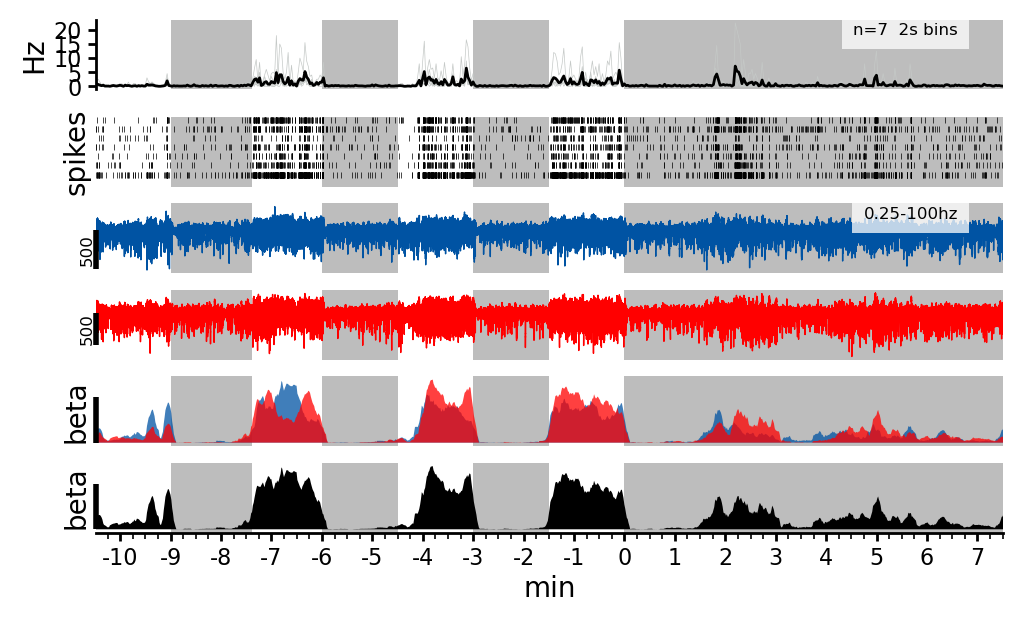

In [18]:
zoom_win = Win(ms(minutes=22.5), ms(minutes=40.5))
filter_pass = (.25, 100)
ref_time = align_wins.sel(exp_name=exp_name, dark_after=True)['ref'].values[0]

f = fig4.plot_single_example_with_spikes(exp_light_wins[exp_name], spikes, beta.downsample(1000), lfp, zoom_win, filter_pass, ref_time)
f.savefig(f'../figs/{exp_name}_detailed_spikes.pdf')

# Fig4 g: eye opening doesn't cause rebounds

  0%|          | 0/5 [00:00<?, ?it/s]

Saving: /gpfs/laur/data/fenkl/from_luis/fig3/beta_vs_eye_open_60_60.pdf


''

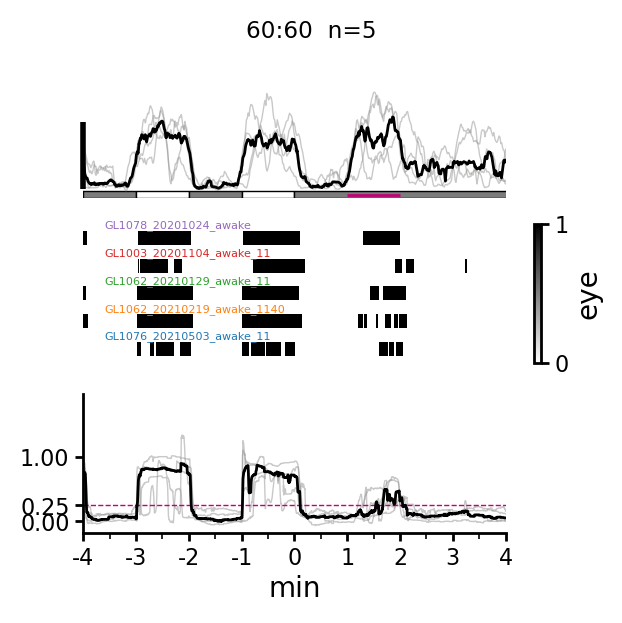

In [19]:
beta_aligned_with_eye = beta_aligned.sel_isin(exp_name=eyes_aligned['exp_name'].unique())

f = fig4.plot_beta_vs_eyes_barcode(
    eyes_aligned.groupby_max('exp_name').normalize_by_quantiles(),
    beta_aligned_with_eye.sel(pulse_len=60_000, interval=60_000, dark_after=True),
    light_wins_aligned,
    thresh=.25,
)

fig4.savefig(f, 'beta_vs_eye_open_60_60')

;
